# Pillar Tracking to Force Conversion

## Import of required Packages

In [1]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import tkinter as tk
import matplotlib.pyplot as plt
import imageio
import math
import os
from ipywidgets import Button
from ipywidgets import interact, interact_manual
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
from IPython.display import Image
from xml.dom import minidom

## Selection of Image File

In [2]:
#provide button to trigger file import
def select_images(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.images = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
    #print('Data imported')
    

imageselect = Button(description="Select Image to import")
imageselect.on_click(select_images)

display(imageselect)

### Display Image

Image dimensions are (x, y):  (1176, 840)


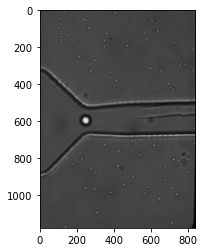

In [3]:
images = imageselect.images #read the file name returned by the button in previous cell
stringa = images[0]
cfile = stringa.replace("/", "\\") #convert file name to Windows format
#print(cfile)

im1 = imageio.imread(cfile) #import image file
im1_x=im1.shape[0]
im1_y=im1.shape[1]
print("Image dimensions are (x, y): ",im1.shape) #print image x,y dimensions

plt.imshow(im1,cmap='gray') #display image file as grayscale
plt.show()

## Import of Tracking Data

### Select Tracking Data File

In [4]:
#provide button to trigger file import
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
    #print('Data imported')
    

fileselect = Button(description="Select Tracking Data to import")
fileselect.on_click(select_files)

display(fileselect)

### Read File and build Array

In [5]:
files = fileselect.files #read the file name returned by the button in previous cell
stringb = files[0] 
dfile = stringb.replace("/", "\\") #convert file name to Windows format

#extract file type for file-type specific import
split_tup = os.path.splitext(dfile)
file_name = split_tup[0] #extract the file name 
file_extension = split_tup[1] #extract the file extension
#print("File Name: ", file_name) #For development only
#print("File Extension: ", file_extension) #For development only

#define file type strings for file-type comparison
str_csv = '.csv'
str_xml = '.xml'

#import data depending on file type
#import for csv files from manual tracking
if file_extension == str_csv: 
    #print("File is a csv") #For development only
    tracks=pd.read_csv(dfile, encoding= 'unicode_escape')
        
    #build list based on t, x, y elements
    pillar_t=tracks.values[:,1]
    pillar_x=tracks.values[:,2]
    pillar_y=tracks.values[:,3]   
    
    number_of_elements = len(tracks) #dtermine number of imported elements
    
#import for xml files from TrackMate tracking
elif file_extension == str_xml: 
    print("File is a xml")
    mydoc = minidom.parse(dfile) #import xml file
    items = mydoc.getElementsByTagName('detection') #selec all xml content labeled "detection"
    number_of_elements = len(items) #determine number of imported elements
    #print(number_of_elements) #For development only

    #build list based on t, x, y elements
    pillar_t=[]
    pillar_x=[]
    pillar_y=[]

    #add xml elements to lists
    def extract_all_xmlelements(list): 
        count = 0
        for element in list:
            pillar_x.append(float(items[count].attributes['x'].value))
            pillar_y.append(float(items[count].attributes['y'].value))
            pillar_t.append(float(items[count].attributes['t'].value))
            #print(items[count].attributes['t'].value, items[count].attributes['x']. value,items[count].attributes['y'].value) #For development only
            count += 1
        return count

    #run list building function and combine to array
    extract_all_xmlelements(items)
    #pillar_Array = np.array([pillar_t,pillar_x,pillar_y]) #For development only
    #print(npArray[1,1]) #For development only
    
#prompt in case file is neither csv nor xml
else: 
    print("File type not supported")

pillar_Array = np.array([pillar_t,pillar_x,pillar_y])

In [6]:
#For development only
#print(pillar_x)
#print(pillar_Array[0])
#print(number_of_elements)

## Data Analysis

### Model Parameter Input

In [7]:
pixel2microns = 21/10 #pixel to micrometer (p2m) coefficient obtained from calibration images
time_base = 1 #frame per second (min)
setpoint_force =0.30 #noise floor for force calculation, not used in current version

pillar_height = 30 #pillar height (um)
pillar_contact = 0.3 * pillar_height #calculate height of hyphal contact point from focussing
pdms_gama = 0.5 #PDMS Poisson’s ratio from F. Schneider, T. Fellner, J. Wilde and U. Wallrabe, J. Micromech. Microeng., 2008, 18, 065008.
pillar_diameter = 7 #pillar diameter (um)
pdms_E = 1.47 #Young's modulus (MPa) 

#E=1.47 MPa, from S. Johari, H. Fazmir, A. F. M. Anuar, M. Z. Zainol, V. Nock and W. Wang, 2015 IEEE Regional Symposium on Micro and Nanoelectronics (RSM), 2015.
#E=2.60 MPa, from F. Schneider, T. Fellner, J. Wilde and U. Wallrabe, J. Micromech. Microeng., 2008, 18, 065008.

pillar_I = math.pi * math.pow(pillar_diameter,4) / 64 #calculate moment of inertia
pillar_area = math.pi * math.pow(pillar_diameter,2) / 4 #calculate pillar area

### Force Calculation

In [8]:
#define pillar center start coordinates
pillar_xstart = pillar_Array[1,0] # read first x-coordinate of pillar centre
pillar_ystart = pillar_Array[2,0] # read first y-coordinate of pillar centre

#build list for displacement delta and forces
delta_x=[]
delta_y=[]
delta_total=[]
force_x=[]
force_y=[]
force_total=[]

#perfom displacement and force calculation as function of number of tracking point "number_of_elements"
count = 0
while count < number_of_elements:
    x_increment = pillar_Array[1,count] # read x-coordinate of current pillar centre
    y_increment = pillar_Array[2,count] # read y-coordinate of current pillar centre
        
    delta_x.append(pixel2microns * (x_increment - pillar_xstart)) # calculate x-deflection relative to initial pillar centre in um
    delta_y.append(pixel2microns * (y_increment - pillar_ystart)); # calculate y-deflection relative to initial pillar centre in um
    delta_total.append(math.pow(math.pow(delta_x[count],2) + math.pow(delta_y[count],2),0.5)) # calculate total deflection relative to initial pillar centre in um

    force_x.append(delta_x[count]/(math.pow(pillar_contact,3)/(3* pdms_E * pillar_I)+ 20*(1+ pdms_gama)* pillar_contact /(9* pillar_area * pdms_E)+ math.pow(pillar_contact,2)*(pillar_height - pillar_contact)/(2* pdms_E * pillar_I))) #calculate force in x-direction
    force_y.append(delta_y[count]/(math.pow(pillar_contact,3)/(3* pdms_E * pillar_I)+ 20*(1+ pdms_gama)* pillar_contact /(9* pillar_area * pdms_E)+ math.pow(pillar_contact,2)*(pillar_height - pillar_contact)/(2* pdms_E * pillar_I))) #calculate force in y-direction

    force_total.append(delta_total[count]/(math.pow(pillar_contact,3)/(3* pdms_E * pillar_I)+ 20*(1+ pdms_gama)* pillar_contact/(9* pillar_area * pdms_E)+ math.pow(pillar_contact,2)*(pillar_height - pillar_contact)/(2* pdms_E * pillar_I))) #calculate total force
    count += 1

#generate time base for plotting based on model input time_base
frames = [i * time_base for i in pillar_t]

#determine average values of force lists (non-zero elements only)
l_x = np.array(list(map(abs, force_x)))
averageF_x = l_x[l_x.nonzero()].mean()
l_y = np.array(list(map(abs, force_y)))
averageF_y = l_y[l_y.nonzero()].mean()
l_t = np.array(list(map(abs, force_total)))
averageF_total = l_t[l_t.nonzero()].mean()

In [9]:
#For development only
#print(pillar_Array)
#print(averageF_x)

### Plot Force Data

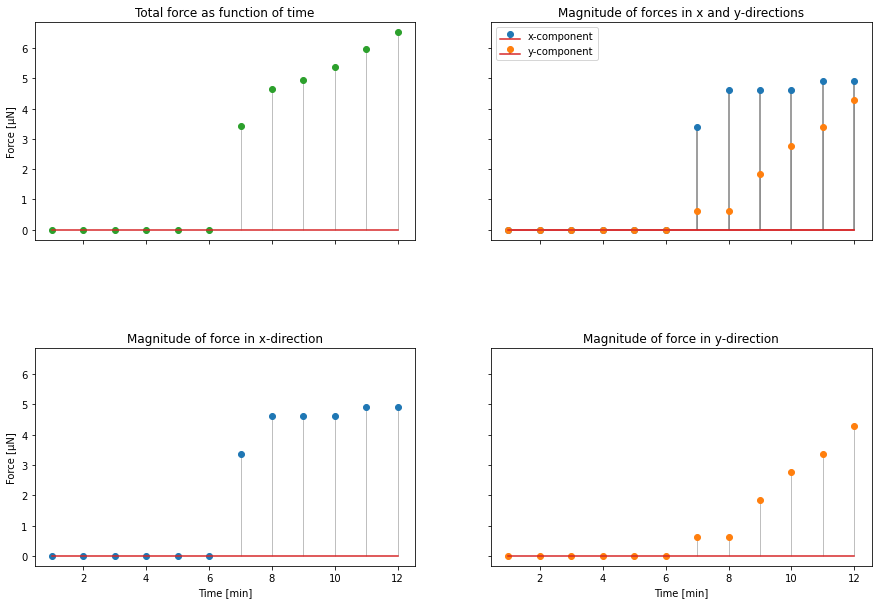

In [31]:
#Plot force data as stemplots
fig, ax = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5)

#subplot(00) : total force
markerline, stemlines, baseline = ax[0,0].stem(frames, force_total, linefmt='grey', markerfmt='C2o')
plt.setp(stemlines,linewidth=0.5)
ax[0,0].set_title('Total force as function of time')
ax[0,0].set(ylabel='Force [μN]')

#subplot(01) : magnitude forces x & y directions
markerline, stemlines, baseline = ax[0,1].stem(frames, list(map(abs, force_x)), linefmt='grey', markerfmt='C0o',label='x-component')
markerline, stemlines, baseline = ax[0,1].stem(frames, list(map(abs, force_y)), linefmt='grey', markerfmt='C1o',label='y-component')
plt.setp(stemlines,linewidth=0.5)
ax[0,1].set_title('Magnitude of forces in x and y-directions')
ax[0,1].legend(loc="upper left")

#subplot(10) : magnitude force x direction
markerline, stemlines, baseline = ax[1,0].stem(frames, list(map(abs, force_x)), linefmt='grey')
plt.setp(stemlines,linewidth=0.5)
ax[1,0].set_title('Magnitude of force in x-direction')
ax[1,0].set(xlabel='Time [min]', ylabel='Force [μN]')

#subplot(11) : magnitude force y direction
markerline, stemlines, baseline = ax[1,1].stem(frames, list(map(abs, force_y)), linefmt='grey', markerfmt='C1o')
plt.setp(stemlines,linewidth=0.5)
ax[1,1].set_title('Magnitude of force in y-direction')
ax[1,1].set(xlabel='Time [min]')


#export plots to pdf file
pdf_name = "%s.pdf" % file_name #generate file name for plot export to pdf from csv or xml file names

plt.savefig(str(pdf_name)) #export all plots to one pdf in image folder
plt.show()

print()

### Export Force Data to csv File

In [14]:
d = {'Frame [#]': pillar_t, 'x Coordinate [pixel]': pillar_x, 'y Coordinate [pixel]': pillar_y, 'Time [min]': frames, 'Total Force [uN]': force_total, 'x Force [uN]': force_x, 'y Force [uN]': force_y,}
df = pd.DataFrame(data=d) #generate array for export to csv

csv_name = "%s_Export.csv" % file_name #generate file name plus "_Export" for data export to csv from csv or xml file names
pd.DataFrame(df).to_csv(str(csv_name)) #export all data to one csv in image folder